In [97]:
from impala.dbapi import connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)
cursor = conn.cursor()

In [38]:
query_q41 = """
SELECT
  Origin,
  Dest,
  COUNT(*) AS TotalFlights,
  SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS CancelledFlights,
  ROUND(SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS CancelRate
FROM flight_data
WHERE Origin IS NOT NULL AND Dest IS NOT NULL
GROUP BY Origin, Dest
HAVING COUNT(*) >= 1000
ORDER BY CancelRate DESC
LIMIT 15
"""
cursor.execute(query_q41)
df_cancel_routes = pd.DataFrame(cursor.fetchall(), columns=["Origin", "Dest", "TotalFlights", "CancelledFlights", "CancelRate"])
df_cancel_routes

,Origin,Dest,TotalFlights,CancelledFlights,CancelRate
0,HPN,ORD,2330,193,8.28
1,ATW,ORD,2402,195,8.12
2,ORD,ATW,2397,192,8.01
3,ASE,DEN,3004,230,7.66
4,BMI,ORD,2436,185,7.59
5,CMH,LGA,3125,236,7.55
6,EWR,IAD,4005,299,7.47
7,DEN,ASE,3000,223,7.43
8,ORD,HPN,2331,173,7.42
9,JFK,ORD,1176,87,7.40


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_52888\986322082.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


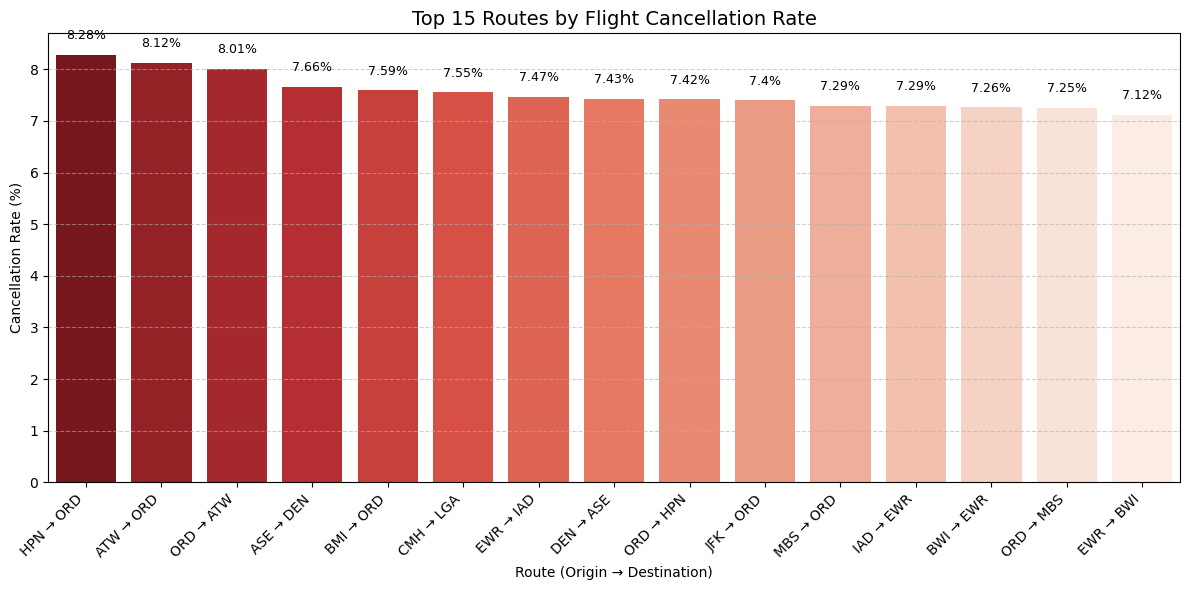

In [39]:
# 新建 Route 字段用于横轴展示
df_cancel_routes["Route"] = df_cancel_routes["Origin"] + " → " + df_cancel_routes["Dest"]

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x="Route",
    y="CancelRate",
    data=df_cancel_routes,
    palette="Reds_r"
)

# 添加标注
for i, row in enumerate(df_cancel_routes.itertuples()):
    ax.text(i, row.CancelRate + 0.3, f"{row.CancelRate}%", ha='center', fontsize=9)

plt.title("Top 15 Routes by Flight Cancellation Rate", fontsize=14)
plt.xlabel("Route (Origin → Destination)")
plt.ylabel("Cancellation Rate (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Q4.1: Routes with the Highest Flight Cancellation Rates

The bar chart above highlights the 15 U.S. domestic routes with the highest flight cancellation rates in 2006. Only routes with at least 1000 flights were included to ensure statistical validity.

#### Key Observations:
- **HPN → ORD** (8.28%) and **ATW → ORD** (8.12%) stand out with the highest cancellation rates, indicating consistent performance issues.
- Several routes are **short-haul connections to Chicago O’Hare (ORD)** — one of the busiest and most delay-prone hubs in the U.S.
- Routes involving **weather-sensitive or regional airports** (e.g., **ASE**, **BMI**, **MBS**) also appear frequently.

#### Implications:
- **Travelers** on these routes should anticipate higher disruption risks and consider booking earlier flights or flexible connections.
- **Airlines** may investigate these routes for potential schedule optimization, ground delay buffering, or infrastructure constraints.
- **ORD (Chicago O’Hare)** appears in many of the worst-performing routes, suggesting systemic congestion or network scheduling impacts.


In [40]:
query_q42 = """
SELECT
  Origin,
  Dest,
  COUNT(*) AS TotalFlights,
  AVG(DepDelay) AS AvgDepDelay
FROM flight_data
WHERE DepDelay IS NOT NULL AND Cancelled = 0
GROUP BY Origin, Dest
HAVING COUNT(*) >= 1000
ORDER BY AvgDepDelay DESC
LIMIT 15
"""
cursor.execute(query_q42)
df_delay_routes = pd.DataFrame(cursor.fetchall(), columns=["Origin", "Dest", "TotalFlights", "AvgDepDelay"])
df_delay_routes

,Origin,Dest,TotalFlights,AvgDepDelay
0,ORD,CAE,1568,35.690051
1,CAE,ORD,1558,34.651476
2,ORD,EWR,7508,27.442461
3,ORD,GSP,2044,27.291096
4,FSD,ORD,1722,26.997677
5,LNK,ORD,1366,26.390190
6,EWR,RIC,1848,26.323593
7,ORF,EWR,1777,26.218346
8,ATL,MCN,1055,26.077725
9,ORD,OKC,1875,25.881067


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_52888\4211230852.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


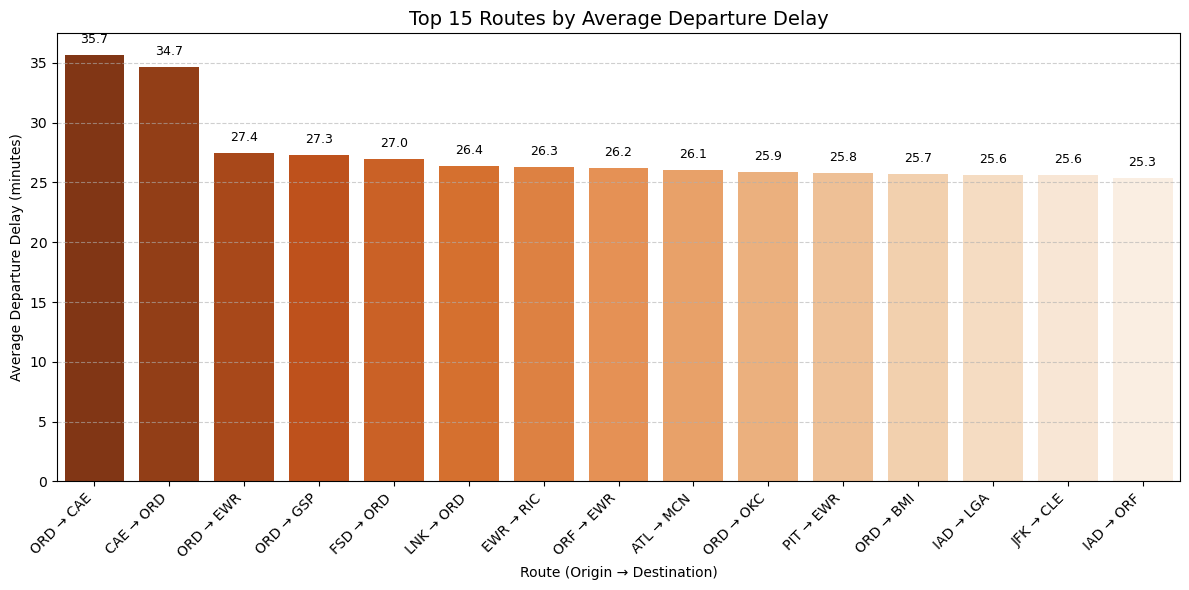

In [41]:
df_delay_routes["Route"] = df_delay_routes["Origin"] + " → " + df_delay_routes["Dest"]

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x="Route",
    y="AvgDepDelay",
    data=df_delay_routes,
    palette="Oranges_r"
)

for i, row in enumerate(df_delay_routes.itertuples()):
    ax.text(i, row.AvgDepDelay + 1, f"{row.AvgDepDelay:.1f}", ha='center', fontsize=9)

plt.title("Top 15 Routes by Average Departure Delay", fontsize=14)
plt.xlabel("Route (Origin → Destination)")
plt.ylabel("Average Departure Delay (minutes)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Q4.2: Routes with the Longest Average Departure Delays

The bar chart above displays the top 15 domestic U.S. routes with the longest average departure delays (in minutes), based on flights in 2006. Only routes with more than 1000 flights were included for statistical reliability.

#### Key Observations:
- **ORD → CAE (35.7 mins)** and **CAE → ORD (34.7 mins)** are by far the worst-performing routes, suggesting systemic two-way issues on this corridor.
- Several other high-delay routes also involve **Chicago O’Hare (ORD)** and **Newark (EWR)**, which are among the most congested and delay-prone hubs.
- Some regional connections (e.g., **FSD → ORD**, **LNK → ORD**, **ORD → OKC**) show unexpectedly long delays, potentially due to tight turnarounds or airport infrastructure limitations.

#### Implications:
- Passengers flying these routes should expect frequent delays and plan connections accordingly.
- Airlines may consider adding buffer time or reevaluating schedules on these problematic segments.
- The recurring appearance of **ORD** and **EWR** suggests that hub congestion and network design play major roles in departure delays.


In [42]:
query_q43_cancel = """
SELECT
  UniqueCarrier AS Carrier,
  COUNT(*) AS TotalFlights,
  SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS CancelledFlights,
  ROUND(SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS CancelRate
FROM flight_data
GROUP BY UniqueCarrier
HAVING COUNT(*) >= 1000
ORDER BY CancelRate DESC
"""
cursor.execute(query_q43_cancel)
df_carrier_cancel = pd.DataFrame(cursor.fetchall(), columns=["Carrier", "TotalFlights", "CancelledFlights", "CancelRate"])
df_carrier_cancel

,Carrier,TotalFlights,CancelledFlights,CancelRate
0,MQ,550088,19990,3.63
1,YV,304764,9544,3.13
2,EV,273143,6783,2.48
3,OH,278099,6875,2.47
4,OO,548109,12844,2.34
5,XE,441470,9716,2.20
6,AQ,35387,745,2.11
7,UA,500008,10238,2.05
8,AA,643597,10127,1.57
9,DL,506086,7695,1.52


In [43]:
query_q43_delay = """
SELECT
  UniqueCarrier,
  COUNT(*) AS TotalFlights,
  AVG(DepDelay) AS AvgDepDelay
FROM flight_data
WHERE DepDelay IS NOT NULL AND Cancelled = 0
GROUP BY UniqueCarrier
HAVING COUNT(*) >= 1000
ORDER BY AvgDepDelay DESC
"""
cursor.execute(query_q43_delay)
df_carrier_delay = pd.DataFrame(cursor.fetchall(), columns=["UniqueCarrier", "TotalFlights", "AvgDepDelay"])
df_carrier_delay

,UniqueCarrier,TotalFlights,AvgDepDelay
0,EV,266360,16.412637
1,YV,295220,14.248852
2,TZ,19375,12.860129
3,UA,489770,11.907026
4,MQ,530098,11.460402
5,B6,155073,11.293913
6,CO,307740,11.025950
7,FL,235704,10.972584
8,AA,633470,10.698082
9,WN,1090370,10.294059


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_52888\606872419.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Carrier", y="CancelRate", data=df_carrier_cancel, palette="Reds_r")


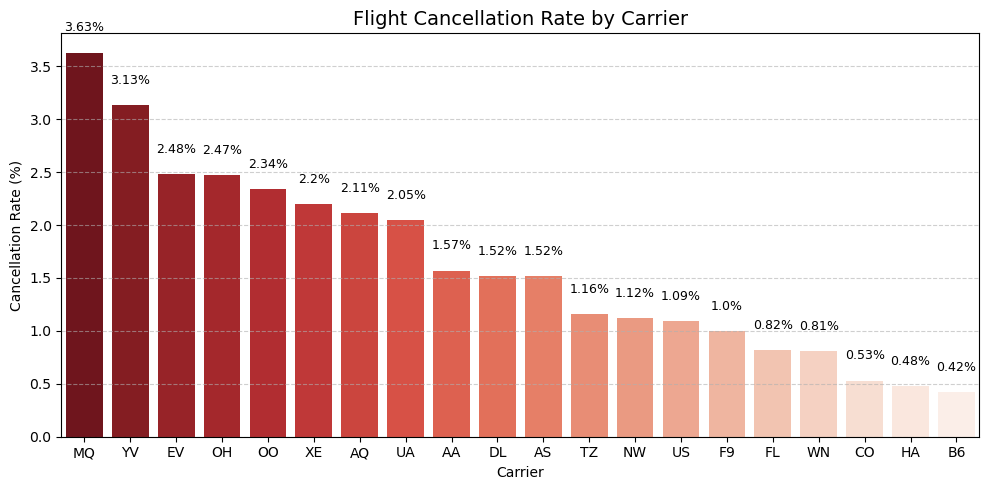

In [44]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="Carrier", y="CancelRate", data=df_carrier_cancel, palette="Reds_r")

for i, row in enumerate(df_carrier_cancel.itertuples()):
    ax.text(i, row.CancelRate + 0.2, f"{row.CancelRate}%", ha='center', fontsize=9)

plt.title("Flight Cancellation Rate by Carrier", fontsize=14)
plt.xlabel("Carrier")
plt.ylabel("Cancellation Rate (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_52888\2115263427.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="UniqueCarrier", y="AvgDepDelay", data=df_carrier_delay, palette="Oranges_r")


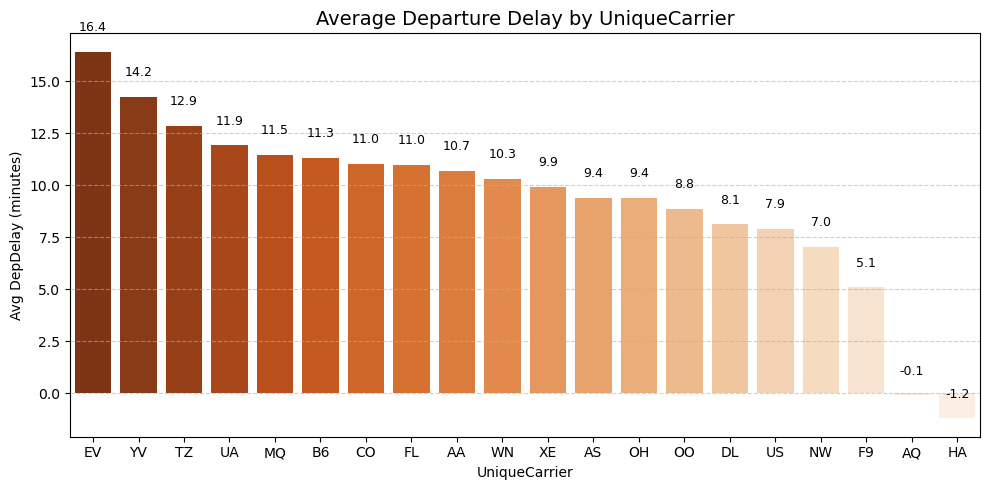

In [45]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="UniqueCarrier", y="AvgDepDelay", data=df_carrier_delay, palette="Oranges_r")

for i, row in enumerate(df_carrier_delay.itertuples()):
    ax.text(i, row.AvgDepDelay + 1, f"{row.AvgDepDelay:.1f}", ha='center', fontsize=9)

plt.title("Average Departure Delay by UniqueCarrier", fontsize=14)
plt.xlabel("UniqueCarrier")
plt.ylabel("Avg DepDelay (minutes)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Q4.3: Carrier-Level Delay and Cancellation Analysis

In this part, we looked at how different airlines performed by comparing:
- Average departure delay (in minutes)
- Flight cancellation rate (percentage)

---

#### Observations:

- **MQ (Envoy Air)** and **YV (Mesa Airlines)** had the highest cancellation rates at 3.63% and 3.13%, meaning their flights were more likely to be canceled.
- **EV (ExpressJet)** had both a high cancellation rate (about 2.5%) and the worst average delay (over 16 minutes), showing weak performance overall.
- Major airlines like **AA (American Airlines)** and **DL (Delta)** had average results, while smaller regional carriers tended to have higher delays.

---

#### Summary:

- When choosing flights, passengers may want to avoid airlines with high delays or cancellation rates.
- Airlines with serious delay issues might need better scheduling or extra buffer time to improve punctuality.


In [48]:
query_q44 = """
SELECT
  FlightNum,
  COUNT(*) AS TotalFlights,
  SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS CancelledFlights,
  ROUND(SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS CancelRate,
  ROUND(AVG(DepDelay), 2) AS AvgDepDelay
FROM flight_data
GROUP BY FlightNum
HAVING COUNT(*) >= 100
ORDER BY AvgDepDelay DESC
LIMIT 30
"""
cursor.execute(query_q44)
df_flightnum_delay = pd.DataFrame(cursor.fetchall(), columns=["FlightNum", "TotalFlights", "CancelledFlights", "CancelRate", "AvgDepDelay"])
df_flightnum_delay.head()


,FlightNum,TotalFlights,CancelledFlights,CancelRate,AvgDepDelay
0,7465,152,9,5.92,50.76
1,7458,166,9,5.42,50.70
2,7426,103,21,20.39,50.09
3,7472,174,17,9.77,47.59
4,7363,220,17,7.73,47.38


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_52888\3758442251.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="FlightNum", y="AvgDepDelay", data=df_flightnum_delay, palette="Reds_r")


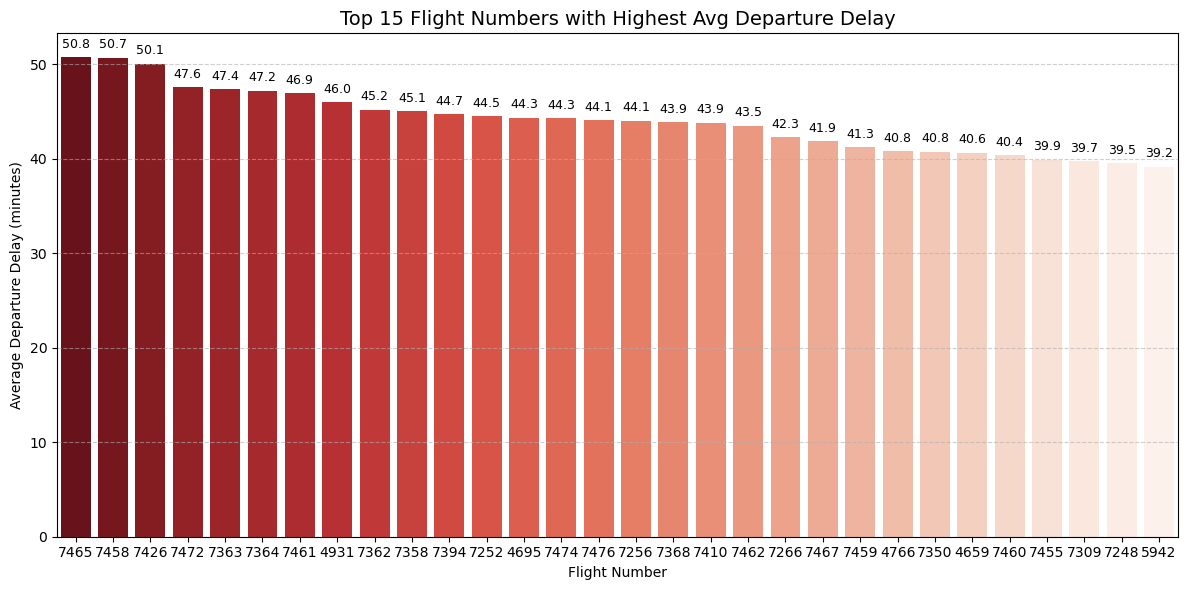

In [49]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="FlightNum", y="AvgDepDelay", data=df_flightnum_delay, palette="Reds_r")

for i, row in df_flightnum_delay.iterrows():
    ax.text(i, row["AvgDepDelay"] + 1, f"{row['AvgDepDelay']:.1f}", ha='center', fontsize=9)

plt.title("Top 15 Flight Numbers with Highest Avg Departure Delay", fontsize=14)
plt.xlabel("Flight Number")
plt.ylabel("Average Departure Delay (minutes)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Q4.4：航班号层面的延误和取消情况分析

我们对飞行次数超过 100 次的航班号进行了统计，并挑选出平均出发延误时间最高的前 30 个航班号进行分析。

---

#### 主要发现：

- 排名前 3 的航班号分别是 **7465、7458、7426**，平均出发延误时间都超过了 **50 分钟**。
- 图中所有航班号的平均延误均超过 39 分钟，说明它们的整体准点表现较差。
- 这类航班可能与拥堵机场、天气影响大或排班紧凑有关。

---

#### 小结：

- 旅客在选择航班时可以尽量避开这些高延误率的航班号。
- 航空公司应重点排查这些航班背后的运营问题（如始发机场、时段安排、前序航班延误传递等）。


# Q4进一步分析

### Q4.4 延伸分析（一）：高延误航班号的起飞时间段是否影响延误？

我们想了解平均延误时间最高的这些航班号，是否集中在某些特定时间段（如清晨、傍晚、深夜）起飞。这可能揭示“时间段”和“延误风险”之间的关联。


In [52]:
query_q44_time = """
SELECT
  FlightNum,
  FLOOR(DepTime / 100) AS DepHour,
  COUNT(*) AS NumFlights,
  ROUND(AVG(DepDelay), 2) AS AvgDelay
FROM flight_data
WHERE FlightNum IN (7465, 7458, 7426, 7472, 7363, 7364, 7461, 4931, 7362, 7358,
                    7394, 7252, 4695, 7474, 7476, 7256, 7368, 7410, 7462, 7266,
                    7467, 7459, 4766, 7350, 4659, 7460, 7455, 7309, 7248, 5942)
  AND DepTime IS NOT NULL
GROUP BY FlightNum, FLOOR(DepTime / 100)
ORDER BY FlightNum, DepHour
"""
cursor.execute(query_q44_time)
df_flightnum_dephour = pd.DataFrame(cursor.fetchall(), columns=["FlightNum", "DepHour", "NumFlights", "AvgDelay"])
df_flightnum_dephour.head()


,FlightNum,DepHour,NumFlights,AvgDelay
0,4659,7,2,5.00
1,4659,11,38,-0.82
2,4659,12,13,33.15
3,4659,13,11,32.00
4,4659,14,53,8.77


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_52888\729506862.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="DepHour", y="AvgDelay", data=df_flightnum_dephour, palette="YlOrRd")


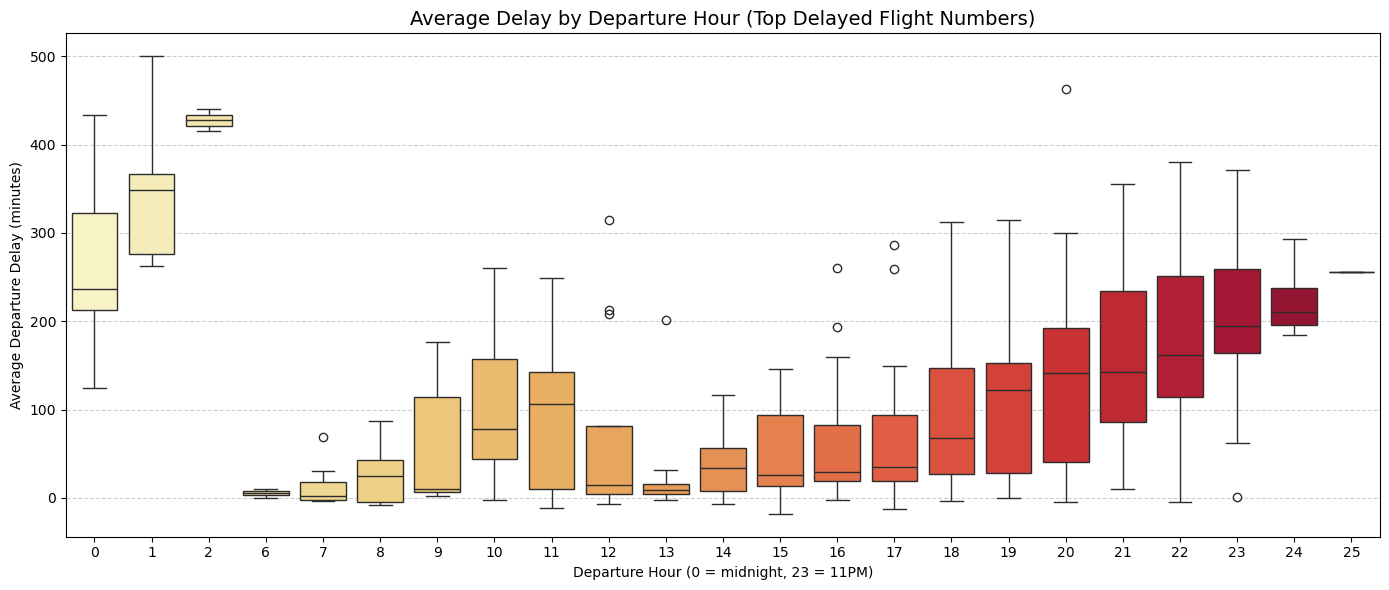

In [53]:
plt.figure(figsize=(14, 6))
ax = sns.boxplot(x="DepHour", y="AvgDelay", data=df_flightnum_dephour, palette="YlOrRd")

plt.title("Average Delay by Departure Hour (Top Delayed Flight Numbers)", fontsize=14)
plt.xlabel("Departure Hour (0 = midnight, 23 = 11PM)")
plt.ylabel("Average Departure Delay (minutes)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Q4.4 Extension Summary (DepTime vs Delay)

The chart shows:

- Many of the most delayed flights depart between **midnight and 2 AM**, with extremely high average delays—some over 400 minutes. This may be due to late-night operations, reduced staffing, or delay propagation.
- Flights between **8 PM and 1 AM** also show significantly higher delays.
- In contrast, **morning flights (6–9 AM)** tend to have the lowest delay rates.

This suggests that departure time is closely related to delay severity, with late-night flights facing more operational risk.


### Q4.4 延伸分析（二）：这些高延误航班是否集中于某些起飞机场？

本部分将分析高延误航班号（FlightNum）是否主要从几个特定机场（Origin）起飞，判断机场是否与航班延误有关。


In [56]:
query_q44_origin = """
SELECT
  FlightNum,
  Origin,
  COUNT(*) AS NumFlights,
  ROUND(AVG(DepDelay), 2) AS AvgDelay
FROM flight_data
WHERE FlightNum IN (7465, 7458, 7426, 7472, 7363, 7364, 7461, 4931, 7362, 7358,
                    7394, 7252, 4695, 7474, 7476, 7256, 7368, 7410, 7462, 7266,
                    7467, 7459, 4766, 7350, 4659, 7460, 7455, 7309, 7248, 5942)
GROUP BY FlightNum, Origin
ORDER BY AvgDelay DESC
"""
cursor.execute(query_q44_origin)
df_flightnum_origin = pd.DataFrame(cursor.fetchall(), columns=["FlightNum", "Origin", "NumFlights", "AvgDelay"])
df_flightnum_origin.head()


,FlightNum,Origin,NumFlights,AvgDelay
0,7363,MDT,1,260.00
1,7410,AVP,39,83.40
2,7467,MSN,55,67.83
3,7455,BMI,47,66.79
4,7465,ORD,110,62.04


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_52888\2896951078.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




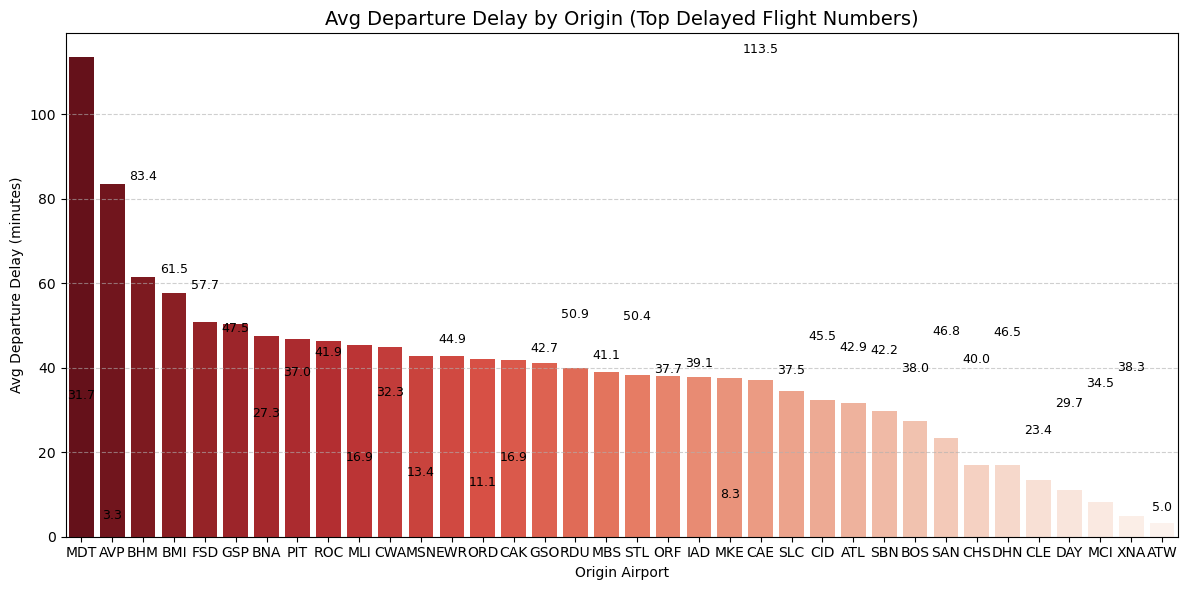

In [76]:
# 聚合分析：哪些机场起飞的这些航班最容易延误
df_origin_grouped = df_flightnum_origin.groupby("Origin").agg(
    TotalFlights=("NumFlights", "sum"),
    AvgDepDelay=("AvgDelay", "mean")
).reset_index()

df_origin_sorted = df_origin_grouped.sort_values(by="AvgDepDelay", ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Origin", y="AvgDepDelay", data=df_origin_sorted, palette="Reds_r")

for i, row in df_origin_sorted.iterrows():
    ax.text(i, row["AvgDepDelay"] + 1, f"{row['AvgDepDelay']:.1f}", ha='center', fontsize=9)

plt.title("Avg Departure Delay by Origin (Top Delayed Flight Numbers)", fontsize=14)
plt.xlabel("Origin Airport")
plt.ylabel("Avg Departure Delay (minutes)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


query_q44_geo = """
SELECT
  FlightNum,
  Origin,
  ROUND(AVG(DepDelay), 2) AS AvgDepDelay
FROM flight_data
WHERE DepDelay IS NOT NULL
GROUP BY FlightNum, Origin
HAVING COUNT(*) >= 50
ORDER BY AvgDepDelay DESC
LIMIT 50
"""
cursor.execute(query_q44_geo)
df_origin_geo = pd.DataFrame(cursor.fetchall(), columns=["FlightNum", "Origin", "AvgDepDelay"])


In [116]:
airport_coords = {
    "MDT": (40.1935, -76.7634),
    "AVP": (41.3385, -75.7234),
    "BHM": (33.5629, -86.7535),
    "BMI": (40.4771, -88.9159),
    "FSD": (43.5820, -96.7419),
    "GSP": (34.8956, -82.2189),
    "BNA": (36.1245, -86.6782),
    "PIT": (40.4915, -80.2329),
    "ROC": (43.1189, -77.6724),
    "MLI": (41.4485, -90.5075),
    "CWA": (44.7776, -89.6668),
    "MSN": (43.1399, -89.3375),
    "EWR": (40.6895, -74.1745),
    "ORD": (41.9742, -87.9073),
    "CAK": (40.9161, -81.4422),
    "GSO": (36.0978, -79.9373),
    "RDU": (35.8776, -78.7875),
    "MBS": (43.5329, -84.0797),
    "STL": (38.7487, -90.3700),
    "ORF": (36.8946, -76.2012),
    "IAD": (38.9531, -77.4565),
    "MKE": (42.9472, -87.8966),
    "CAE": (33.9388, -81.1195),
    "SLC": (40.7899, -111.9791),
    "CID": (41.8847, -91.7108),
    "ATL": (33.6407, -84.4277),
    "SBN": (41.7087, -86.3173),
    "BOS": (42.3656, -71.0096),
    "SAN": (32.7336, -117.1897),
    "CHS": (32.8986, -80.0405),
    "DHN": (31.3213, -85.4496),
    "CLE": (41.4117, -81.8498),
    "DAY": (39.9024, -84.2194),
    "MCI": (39.2976, -94.7139),
    "XNA": (36.2819, -94.3068),
    "ATW": (44.2581, -88.5191)
}

# 假设你已经有 airport_coords 字典（包含 Origin 的经纬度）
df_flightnum_origin["Lat"] = df_flightnum_origin["Origin"].map(lambda x: airport_coords.get(x, (None, None))[0])
df_flightnum_origin["Lon"] = df_flightnum_origin["Origin"].map(lambda x: airport_coords.get(x, (None, None))[1])

# 去除经纬度缺失值
df_flightnum_origin = df_flightnum_origin.dropna(subset=["Lat", "Lon"])



C:\Users\PC - MAKMAL DELTA\anaconda3\Lib\site-packages\matplotlib\collections.py:1008: RuntimeWarning:

invalid value encountered in sqrt



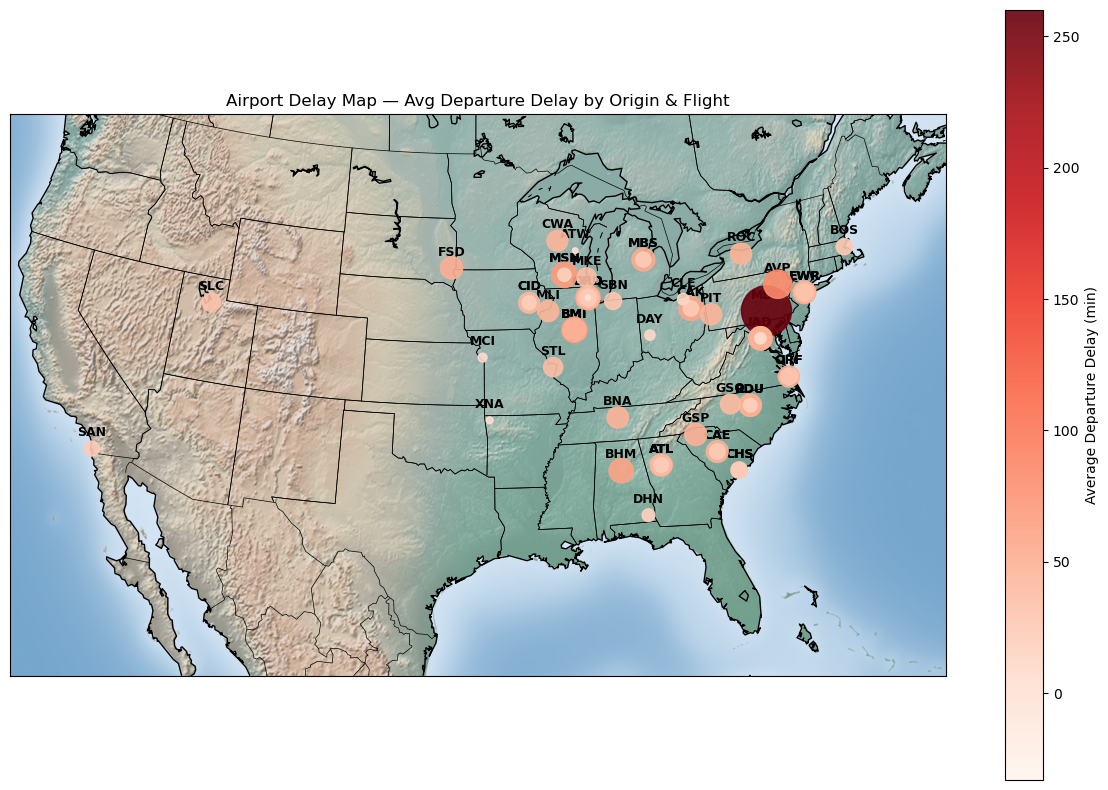

In [128]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# 初始化美国地图
m = Basemap(
    projection='lcc', resolution='l',
    lat_0=37.5, lon_0=-95,
    width=5E6, height=3E6
)

# 加入地图元素
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.shadedrelief()

# 经纬度转投影坐标
x, y = m(df_flightnum_origin["Lon"].values, df_flightnum_origin["Lat"].values)

# 用延误值设置大小和颜色
sc = m.scatter(
    x, y,
    c=df_flightnum_origin["AvgDelay"],
    s=df_flightnum_origin["AvgDelay"] * 5,
    cmap="Reds", alpha=0.9, zorder=5
)

# 添加标注：机场在上，航班号在下
for i, row in df_flightnum_origin.iterrows():
    xpt, ypt = m(row["Lon"], row["Lat"])
    plt.text(xpt, ypt + 50000, row["Origin"], fontsize=9, ha='center', va='bottom', fontweight='bold', color='black')
    #plt.text(xpt, ypt - 50000, f"#{row['FlightNum']}", fontsize=8, ha='center', va='top', color='gray')

plt.colorbar(sc, label="Average Departure Delay (min)")
plt.title("Airport Delay Map — Avg Departure Delay by Origin & Flight")
plt.tight_layout()
plt.show()


In [129]:
df_flightnum_origin.head(10)

,FlightNum,Origin,NumFlights,AvgDelay,Lat,Lon
0,7363,MDT,1,260.00,40.1935,-76.7634
1,7410,AVP,39,83.40,41.3385,-75.7234
2,7467,MSN,55,67.83,43.1399,-89.3375
3,7455,BMI,47,66.79,40.4771,-88.9159
4,7465,ORD,110,62.04,41.9742,-87.9073
5,4931,BHM,2,61.50,33.5629,-86.7535
6,7458,CAK,55,59.22,40.9161,-81.4422
7,7472,ORD,130,57.38,41.9742,-87.9073
8,7309,IAD,40,56.46,38.9531,-77.4565
9,7410,BMI,25,56.24,40.4771,-88.9159


### Q4.4 Extension II: Departure Airports for Severely Delayed Flight Numbers

This section explores whether the flight numbers with the highest average departure delays tend to originate from particular airports.

#### Key Findings:

- The **bar chart** shows that **MDT (Harrisburg)** and **AVP (Scranton)** stand out with the highest average departure delays (over 80 minutes), significantly exceeding the overall average.
- **BHM, BMI, FSD, GSP**, and several Midwest airports also show prolonged delays, indicating **regional bottlenecks or operational issues**.
- In contrast, major hubs like **ATL (Atlanta)** and **ORD (Chicago O'Hare)** show moderate delays, possibly due to better infrastructure and recovery capacity.

#### Geospatial Insight:

- The **map visualization** confirms that the most delayed flights originate predominantly in the **Midwest and Northeast regions**.
- Clusters of red-shaded airports with large circles emphasize systemic delays in those areas.
- These patterns suggest that **regional weather patterns, limited ground support, or fewer recovery options** may play a role.

#### Implications:

- **Passengers** traveling from MDT, AVP, and similar airports should anticipate a higher risk of delays.
- **Airlines** operating in these regions may consider targeted improvements such as:
  - Buffering schedules
  - Enhancing gate/crew availability
  - Strategic aircraft positioning
